In [ ]:
import json
import os
import torch
import matplotlib.pyplot as plt
from utils import ModelModule, DataModule
from utils.opts import test_model

In [ ]:
def get_datamodule(config_path, embedding_path):
    with open(config_path, 'r') as f:
        xai_config = json.load(f)
        xai_config['embedding_path'] = embedding_path
        datamodule = DataModule.from_config(xai_config)
        return datamodule
    
def test(modelmodule:ModelModule, testdata:DataModule, weight_path:str, device='cpu'):
    _model = modelmodule.build_model(
        device=device,
        dtype=testdata.dtype,
        hidden_dim=testdata.hidden_dim
    )
    _weight_path = weight_path
    _state_dict = torch.load(_weight_path, map_location=device)
    print(f'[ACT] Resumed from {_weight_path}')
    _model.load_state_dict(_state_dict)
    y_true, y_pred = test_model(
        model=_model,
        dataloader=testdata.dataloader,
        device=device
    )
    return y_true, y_pred, _model

def get_importance_map(model):
    be_cps, ae_cps = [], []
    for cp in model.be_cap.contact_map.numpy():
        cp = cp[1:int((cp > 0).sum(axis=0).max())-1, 1:int((cp > 0).sum(axis=1).max())-1]
        be_cps.append(cp)
        
    for cp in model.ae_cap.contact_map.numpy():
        cp = cp[1:int((cp > 0).sum(axis=0).max())-1, 1:int((cp > 0).sum(axis=1).max())-1]
        ae_cps.append(cp)
    return be_cps, ae_cps

def get_eval_model(config_path, embedding_path):
    with open(config_path, 'r') as f:
        config = json.load(f)
    weight_path = os.path.join(os.path.dirname(config_path), 'best.pt')
    modelmodule = ModelModule.from_config(config['model_configs'])
    datamodule = get_datamodule('data/TCRXAI/55/test_config.json', embedding_path)
    y_true, y_pred, model = test(modelmodule, datamodule, weight_path)
    return y_true, y_pred, model


def get_contact_map(conf, embed):
    y_true, y_pred, model = get_eval_model(conf, embed)
    be_cps, ae_cps = get_importance_map(model)
    return be_cps, ae_cps

In [ ]:
model_configs = [
    ('esm2_t6_8M_UR50D', 'experiments/esm2_t6_8M_UR50D/config.json', 'embeddings/tcrxai/esm2_t6_8M_UR50D'),
    ('proteinbert', 'experiments/proteinbert/config.json', 'embeddings/tcrxai/proteinbert'),
]
contact_maps = {
    i[0]:get_contact_map(i[1], i[2])
    for i in model_configs
}

[ACT] Resumed from experiments/contactareareg/esm2_t6_8M_UR50D_mixbind_maxchain_R80_150/best.pt


[eval; EPOCH=0]: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


[ACT] Resumed from experiments/janetserver/contactareareg/esm2_t12_35M_UR50D_mixbind_maxchain_R80_220/best.pt


[eval; EPOCH=0]: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


[ACT] Resumed from experiments/janetserver/contactareareg/esm2_t33_650M_UR50D_mixbind_maxchain_R80_130/best.pt


[eval; EPOCH=0]: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


[ACT] Resumed from experiments/zachtower/contactareareg/proteinbert_mixbind_maxchain_170/best.pt


[eval; EPOCH=0]: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


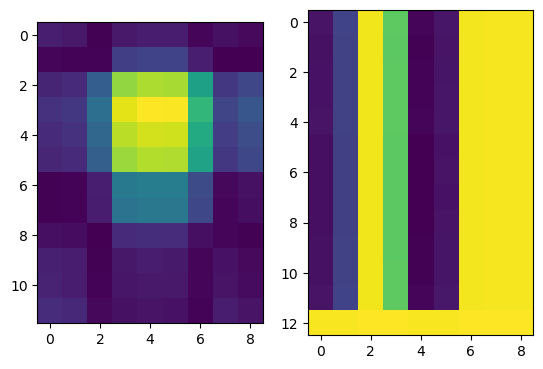

In [51]:
fig = plt.figure()
axes = fig.subplots(1, 2)
axes[0].imshow(contact_maps['proteinbert'][0][32])
axes[1].imshow(contact_maps['proteinbert'][1][32])